In [83]:
#'##########################################################
#	  	 MODEL SELECTION
# 	a sript for  the project
#	DEMOGRAPHIC BUFFERING CONTINUUM in PLANTS AND ANIMALS
#			 by Gabriel Santos
# 	contact by ssantos.gabriel@gmail.com
#			    05 March 2025
#' ---------------------------------------------------------
# Rationale: We must decide between better model composition
# as Environmental PCA included until 3 axes
# revealing these three potential relevant source of information #
#'##########################################################

set.seed(1)

rm(list=ls())

# Define necessary packages
need_pkgs <- c("tidyverse", "plotMCMC", "mcmcr", "MuMIn", "MCMCglmm","MuMIn")

exist_pckgs<-exist_pckgs <- installed.packages()[, "Package"]

if (any(!need_pkgs %in% exist_pckgs)) {   # Check for inexisting packages and install them
  install.packages(need_pkgs[!need_pkgs %in% exist_pckgs])
}


In [84]:
# load non-existing packages
lapply(need_pkgs, require, character.only = TRUE)

rm(list=ls())

In [85]:

#'===========================================================
# ----- LOAD data ready for GLMM analyses ----
# GLMM data contains:
#  - Data model
#  - subtree_Animals - Phylogenetic tree for Animals ready for analysis
#  - subtree_Animals - Phylogenetic tree for Plants ready for analysis
#'===========================================================
# Download data In Google colab
#dir.create(file.path("Data"), showWarnings = FALSE) # Will return warning message if folder already exists
#GLMMdata_link<-"https://github.com/Ecosantos/Demogbuff-pops/raw/refs/heads/incorporating-MCMCGlmm/Data/GLMMdata.Rdata"
#download.file(GLMMdata_link, "Data/GLMMdata.Rdata", mode = "wb")


load("Data/GLMMdata.Rdata")

data_model%>%glimpse()


Rows: 121
Columns: 65
$ ID                     <chr> "Ephr.267_629", "Hypr.463_75…
$ Reproduction_SigElas   <dbl> -3.927846e-04, -5.388396e-02…
$ Growth_SigElas         <dbl> -7.488920e-04, -4.916847e-03…
$ Shrinking_SigElas      <dbl> 3.145980e-05, -1.964465e-03,…
$ Clonality_SigElas      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Survival_SigElas       <dbl> -0.0014496648, -0.1039452087…
$ Cumulative_SigElas     <dbl> 0.0025598816, 0.1647104846, …
$ Buffmx                 <dbl> 1.0005637, 1.1237288, 1.0082…
$ MatRep                 <int> 4, 53, 4, 7, 3, 4, 4, 4, 4, …
$ LHPC.1                 <dbl> 1.3421320, -1.4462016, 0.569…
$ LHPC.2                 <dbl> 0.5178421, -0.6705717, 0.152…
$ ClimPC.1               <dbl> 0.1901417, -1.7561908, 1.859…
$ ClimPC.2               <dbl> -0.28772696, 0.04956925, -0.…
$ ClimPC.3               <dbl> -0.32364884, 0.52991276, 0.1…
$ mat                    <list> <S4 class ‘CompadreMat’ [pa…
$ Pop                    <int> 629, 756, 46, 1204, 472, 322…
$ 

In [86]:


#'===========================================================
# ---- Define priors ----
#'===========================================================


prior_phylo<-list(G=list(G1=list(V=1,nu=0.02)),
                  R=list(V=1,nu=0.02))

# Prior for simple model will be removed.
# It will run with prior_phylo for standardization!
#prior_simple<-list(G=list(R=list(V=1,nu=0.02)))

nitt=100000; #nitt=1000
burnin=1000; #burnin=100
thin=10

glmmScale<-"FALSE"

#'===========================================================
# ---- Create models manually ----
#'===========================================================
# A function was created to reduce code
fit_mcmcglmm <- function(formula) {
  MCMCglmm(
    formula,
    random = ~phylo,
    family = "gaussian",
    ginverse = list(phylo = inverseA(subtree_Plants, nodes = "TIPS", scale = TRUE)$Ainv),
    prior = prior_phylo,
    data = subset(data_model, Kingdom == "Plantae"),
    nitt = nitt,
    burnin = burnin,
    thin = thin,
    singular.ok = TRUE,
    scale = glmmScale,
    verbose=FALSE
  )
}


# Models all interactions
Clim123_allint <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 * ClimPC.1 * ClimPC.2 * ClimPC.3);print("Clim123_allint - OK")
Clim12_allint <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 * ClimPC.1 * ClimPC.2);print("Clim12_allint - OK")

# Models with interactions
Clim123 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2 * ClimPC.3);print("Clim123 - OK")
Clim12 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2);print("Clim12 - OK")
Clim13 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.3);print("Clim13 - OK")
Clim23 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2 * ClimPC.3);print("Clim23 - OK")

#Aditive models
Clim123_plus<-fit_mcmcglmm(Cumulative_SigElas~LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2 + ClimPC.3);print("Clim123_plus - OK")
Clim12_plus<-fit_mcmcglmm(Cumulative_SigElas~LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2);print("Clim12_plus - OK")

# Aditive for life history and climatic data
Clim12_plus_only<-fit_mcmcglmm(Cumulative_SigElas~LHPC.1 + LHPC.2 + ClimPC.1 + ClimPC.2);print("Clim12 plus_only - OK")

# Models with single climatic variable
Clim1 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1);print("Clim1 - OK")
Clim2 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2);print("Clim2 - OK")
Clim3 <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.3);print("Clim3 - OK")

# Null model
All_null <- fit_mcmcglmm(Cumulative_SigElas ~ 1 );print("all_NULL - OK")
Clim_null <- fit_mcmcglmm(Cumulative_SigElas ~ LHPC.1 * LHPC.2 );print("Clim_NULL - OK")




[1] "Clim123_allint - OK"
[1] "Clim12_allint - OK"
[1] "Clim123 - OK"
[1] "Clim12 - OK"
[1] "Clim13 - OK"
[1] "Clim23 - OK"
[1] "Clim123_plus - OK"
[1] "Clim12_plus - OK"
[1] "Clim12 plus_only - OK"
[1] "Clim1 - OK"
[1] "Clim2 - OK"
[1] "Clim3 - OK"
[1] "all_NULL - OK"
[1] "Clim_NULL - OK"


In [87]:
library(MuMIn)

forms<-lapply(
  lapply(
    list(All_null,Clim_null,
         Clim1,Clim2,Clim3,
         Clim123,
         Clim12,Clim13,Clim23,
         Clim123_plus,Clim12_plus,
         Clim12_plus_only,
         Clim123_allint,Clim123_allint),formula),
          function(f) paste(deparse(formula(f)), collapse = ""))%>%do.call(rbind,.)

In [88]:
forms%>%print()

      [,1]                                                                       
 [1,] "Cumulative_SigElas ~ 1"                                                   
 [2,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2"                                     
 [3,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1"                          
 [4,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2"                          
 [5,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.3"                          
 [6,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2 *     ClimPC.3"
 [7,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2"               
 [8,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.3"               
 [9,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2 * ClimPC.3"               
[10,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2 +     ClimPC.3"
[11,] "Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2"               
[12,] "Cumulativ

In [89]:
mod_out<-cbind(formulas=forms,
  BIC(All_null,Clim_null,Clim1,Clim2,Clim3,Clim123,Clim12,Clim13,Clim23,Clim123_plus,Clim12_plus,Clim12_plus_only,Clim123_allint,Clim12_allint),
  AIC=AIC(All_null,Clim_null,Clim1,Clim2,Clim3,Clim123,Clim12,Clim13,Clim23,Clim123_plus,Clim12_plus,Clim12_plus_only,Clim123_allint,Clim12_allint)[,2],
  DIC=DIC(All_null,Clim_null,Clim1,Clim2,Clim3,Clim123,Clim12,Clim13,Clim2,Clim123_plus,Clim12_plus,Clim12_plus_only,Clim123_allint,Clim12_allint)[,2])%>%
  arrange(DIC)

mod_out

                                                                                  formulas
Clim123          Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2 *     ClimPC.3
Clim12                          Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2
All_null                                                            Cumulative_SigElas ~ 1
Clim3                                      Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.3
Clim2                                      Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2
Clim23                          Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.2 * ClimPC.3
Clim12_plus_only                Cumulative_SigElas ~ LHPC.1 + LHPC.2 + ClimPC.1 + ClimPC.2
Clim12_plus                     Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2
Clim123_plus     Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 + ClimPC.2 +     ClimPC.3
Clim13                          Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.3

#### Model with additive paramenters only (Best models)

In [90]:
summary(Clim12_plus_only)


 Iterations = 1001:99991
 Thinning interval  = 10
 Sample size  = 9900 

 DIC: -401.2667 

 G-structure:  ~phylo

      post.mean l-95% CI u-95% CI eff.samp
phylo    0.2258   0.1567   0.3029     9777

 R-structure:  ~units

      post.mean  l-95% CI u-95% CI eff.samp
units  0.001312 0.0007421 0.001967     9744

 Location effects: Cumulative_SigElas ~ LHPC.1 + LHPC.2 + ClimPC.1 + ClimPC.2 

            post.mean  l-95% CI  u-95% CI eff.samp  pMCMC
(Intercept)  0.054518 -0.295379  0.429588     9900 0.7576
LHPC.1      -0.007832 -0.016653  0.000856     9900 0.0754
LHPC.2       0.001916 -0.009488  0.012675    10332 0.7283
ClimPC.1     0.023166 -0.005139  0.051532     9900 0.1026
ClimPC.2     0.042952  0.023709  0.063157     9900 <1e-04
               
(Intercept)    
LHPC.1      .  
LHPC.2         
ClimPC.1       
ClimPC.2    ***
---
Signif. codes:  
0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

#### Model with interaction

In [91]:
summary(Clim12)


 Iterations = 1001:99991
 Thinning interval  = 10
 Sample size  = 9900 

 DIC: -437.8027 

 G-structure:  ~phylo

      post.mean l-95% CI u-95% CI eff.samp
phylo    0.2088   0.1338    0.335    24.68

 R-structure:  ~units

      post.mean  l-95% CI u-95% CI eff.samp
units  0.002751 0.0006732 0.002745    12.59

 Location effects: Cumulative_SigElas ~ LHPC.1 * LHPC.2 + ClimPC.1 * ClimPC.2 

                  post.mean  l-95% CI  u-95% CI eff.samp
(Intercept)        0.070390 -0.288578  0.413719 10019.83
LHPC.1            -0.009085 -0.019165  0.001009   136.88
LHPC.2            -0.006138 -0.022447  0.011440   257.45
ClimPC.1           0.013551 -0.019439  0.048890   378.16
ClimPC.2           0.037915  0.013515  0.063053   479.45
LHPC.1:LHPC.2      0.006112 -0.003727  0.014707    42.25
ClimPC.1:ClimPC.2  0.012242 -0.007964  0.033678    77.60
                   pMCMC  
(Intercept)       0.6725  
LHPC.1            0.0586 .
LHPC.2            0.4675  
ClimPC.1          0.4291  
ClimPC.2       

# Save file 
save all models if necessary to check modelselection and model validation

In [53]:
save(
All_null,Clim_null,Clim1,Clim2,Clim3,Clim123,Clim12,Clim13,Clim23,Clim123_plus,Clim12_plus,Clim12_plus_only,Clim123_allint,Clim12_allint, 
file = "Data/competing models.RData")

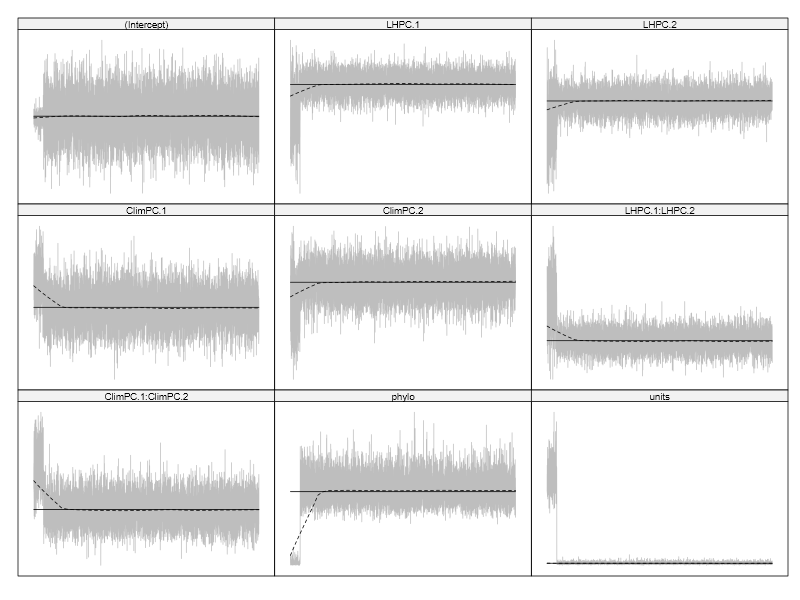

In [95]:
Chains_Clim12 <- mcmcr::as.mcmc(cbind(Clim12$Sol,Clim12$VCV))
plotMCMC::plotTrace(Chains_Clim12 )

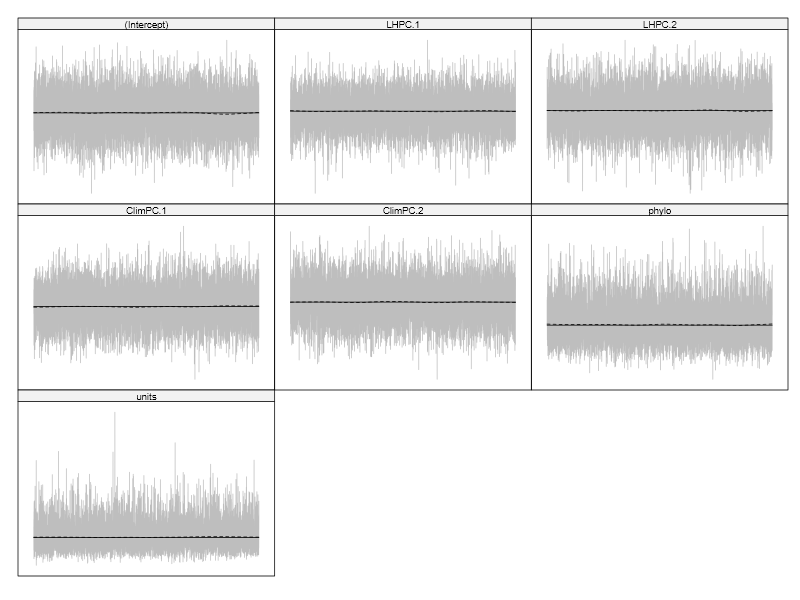

In [94]:
Chains_Clim12_plus_only <- mcmcr::as.mcmc(cbind(Clim12_plus_only$Sol,Clim12_plus_only$VCV))
plotMCMC::plotTrace(Chains_Clim12_plus_only)